- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 오버피팅을 줄이면서 90% 이상의 정확도를 가지는 아키텍쳐 구현

In [1]:
# validation data 양이 최소 train data 양의 10%는 넘어야 함

In [5]:
#Open_CV
# Classification --> CNN, TL
# Detection -->fast R-CNN, Yolo8, SSD
# Segmentation --> Unet

# validation data number 가 부족함 --> validation data will be extracted from train data set
# Original validation data will be moved to test data set

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
## GPU 사용 유무 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-07-05 15:21:08.061228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 15:21:09.383665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-05 15:21:09.387578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-05 15:21:09.387825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been bu

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10750345823004593863
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9824108544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16909472173568436807
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Project -1

### 경로 설정

In [6]:
#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

/tf/Kaggle Portfolio


In [7]:
#### PC
ROOT_DIR = "/tf/Kaggle Portfolio"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")

### 데이터셋 가져오기

In [10]:
# #### Colab
# from google.colab import drive

# drive.mount("/content/gdrive")

# data_path = "/content/gdrive/MyDrive/Colab Notebooks"

# shutil.copy(os.path.join(data_path, "Chest_Xray_Pneumonia.zip"), ROOT_DIR) # zip file name
    
# with zipfile.ZipFile(os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia.zip"), "r") as target_file:
#     target_file.extractall(DATA_ROOT_DIR)

In [8]:
#### PC

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, "archive_pneumonia.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

#Data 재가공 불필요한 file 정리 후 colab에 사용하기위한 알맞는 data set form(train, test, val)으로 압축

### 데이터 경로 재설정

In [22]:
#### PC
ROOT_DIR = "/tf/Kaggle Portfolio/Chest_Xray_Pneumonia"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "chest_xray")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")


### 정답 및 전체 데이터 갯수 확인

In [23]:
##### 훈련 데이터 갯수

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('test label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    
print('=====================================================')

##### 평가 데이터 갯수
validation_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)
print(validation_label_name_list)

for label_name in validation_label_name_list:
    print('validation label : ', label_name,' => ', 
          len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))


['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1341
train label :  PNEUMONIA  =>  3875
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  234
test label :  PNEUMONIA  =>  390
['NORMAL', 'PNEUMONIA']
validation label :  NORMAL  =>  8
validation label :  PNEUMONIA  =>  8


### Image Shape 설정

In [24]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset = "training")

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              subset = "validation")


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [28]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]
print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


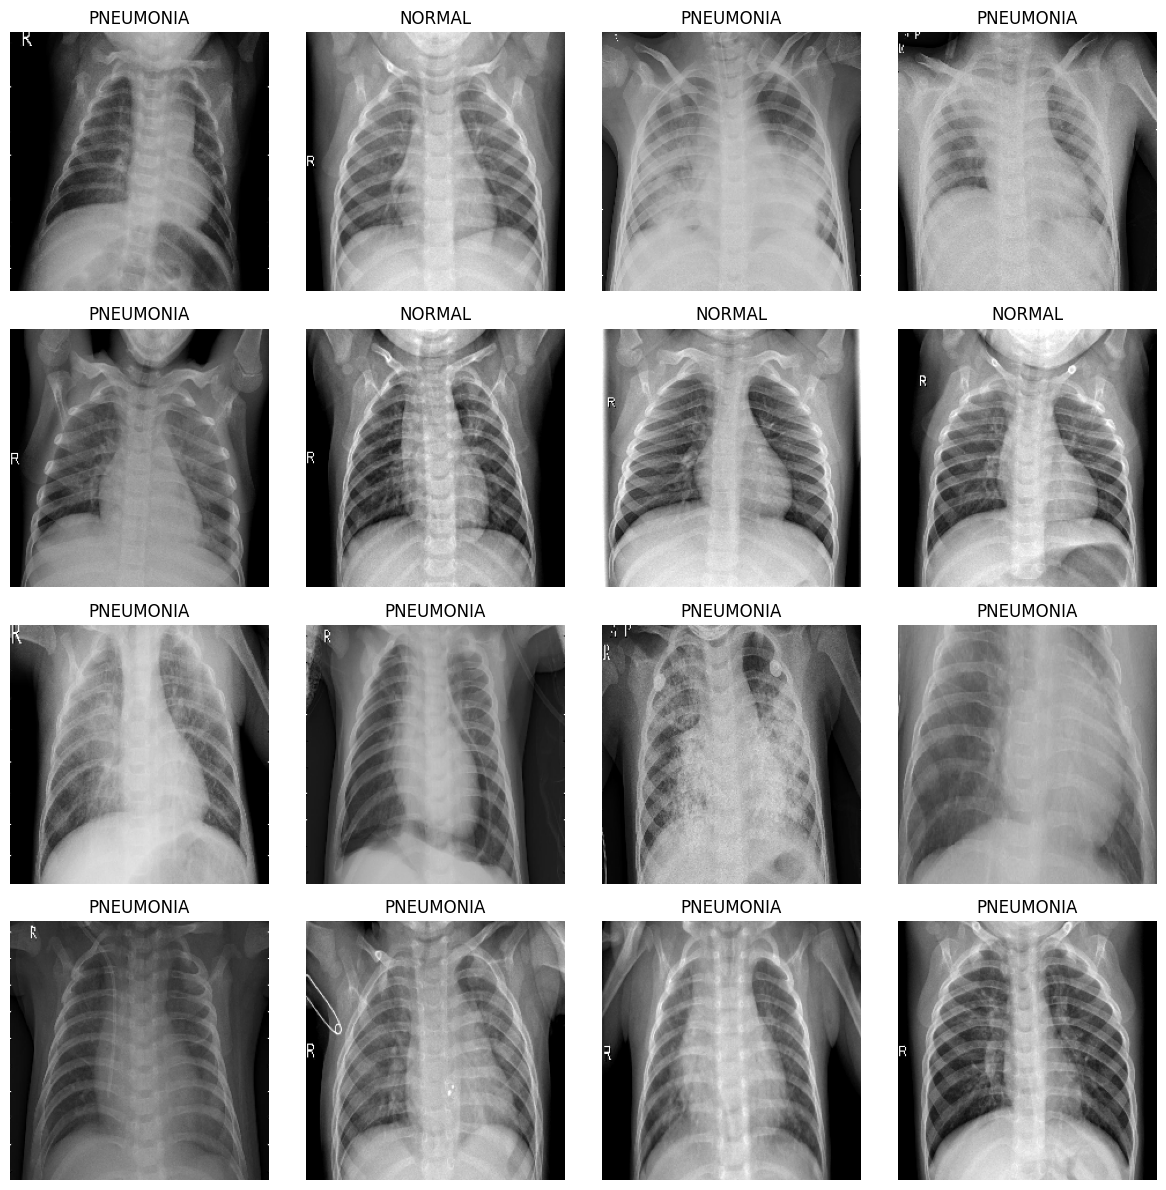

In [29]:
plt.figure(figsize=(12, 12))

class_dict = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(len(label)):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [30]:
#MobilNet 을 이용한 deep learning 모델 학습
pre_trained_model = MobileNet(weights="imagenet", include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [31]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                16400     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
No

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(2e-5), metrics=["accuracy"])

In [33]:
start_time = datetime.now()

# epochs = 30
result = model.fit(train_generator, epochs= 40, validation_data=validation_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/40


2023-07-05 16:01:24.226374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


131/131 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.7795

2023-07-05 16:02:02.772318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


131/131 [==============================] - 46s 290ms/step - loss: 0.4357 - accuracy: 0.7795 - val_loss: 0.5446 - val_accuracy: 0.7862
Epoch 2/40
131/131 [==============================] - 38s 285ms/step - loss: 0.1749 - accuracy: 0.9327 - val_loss: 0.3195 - val_accuracy: 0.8725
Epoch 3/40
131/131 [==============================] - 41s 314ms/step - loss: 0.1233 - accuracy: 0.9554 - val_loss: 0.2273 - val_accuracy: 0.9060
Epoch 4/40
131/131 [==============================] - 39s 296ms/step - loss: 0.1084 - accuracy: 0.9626 - val_loss: 0.0824 - val_accuracy: 0.9655
Epoch 5/40
131/131 [==============================] - 38s 291ms/step - loss: 0.0758 - accuracy: 0.9734 - val_loss: 0.0558 - val_accuracy: 0.9779
Epoch 6/40
131/131 [==============================] - 39s 297ms/step - loss: 0.0721 - accuracy: 0.9748 - val_loss: 0.0422 - val_accuracy: 0.9866
Epoch 7/40
131/131 [==============================] - 38s 289ms/step - loss: 0.0589 - accuracy: 0.9813 - val_loss: 0.0338 - val_accuracy: 0.9

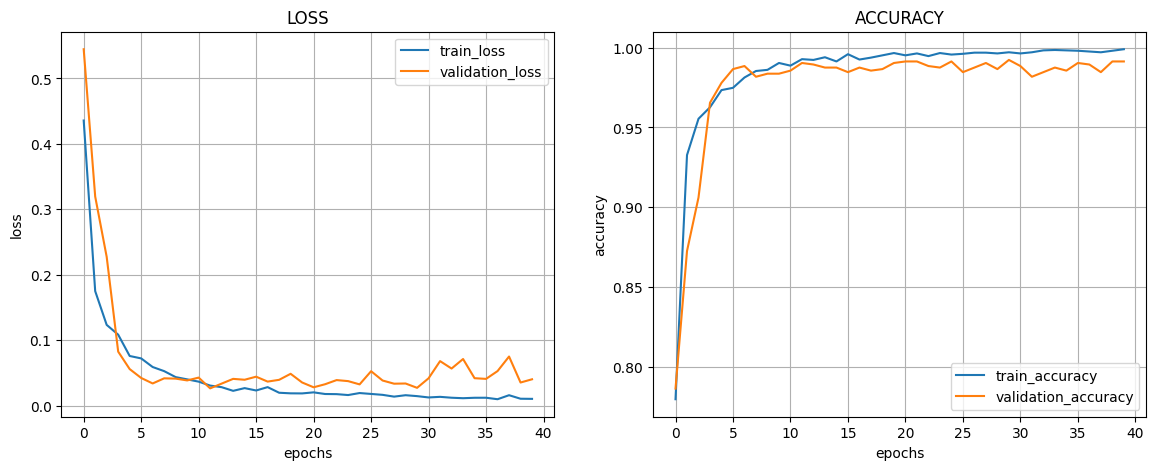

In [34]:
#LOSS graph
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

#ACCURACY graph
plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")


In [38]:
print(model.evaluate(train_generator))

2023-07-05 16:46:44.389070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


131/131 [==============================] - 30s 230ms/step - loss: 1.6097e-05 - accuracy: 1.0000
[1.609715400263667e-05, 1.0]


In [39]:
print(model.evaluate(test_generator))

2023-07-05 16:47:14.876653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 4s 198ms/step - loss: 1.6094 - accuracy: 0.7933
[1.6094342470169067, 0.7932692170143127]


In [40]:
print(model.evaluate(validation_generator))

2023-07-05 16:48:22.300195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 7s 217ms/step - loss: 0.0402 - accuracy: 0.9914
[0.040164344012737274, 0.9913710355758667]


In [36]:
test_simple_dataget = ImageDataGenerator(rescale = 1./255)

test_simple_generator = train_datagen.flow_from_directory(VALIDATION_DATA_ROOT_DIR, 
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 16 images belonging to 2 classes.


In [37]:
model.evaluate(test_simple_generator)

2023-07-05 16:28:31.177591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 297ms/step - loss: 0.0096 - accuracy: 1.0000


[0.009579095989465714, 1.0]

### Project -1 loss, accuracy 확인
#### Model architecture
- pretrained model : MobileNet(weights=imagenet) - F - D - D
- dropout: 0.5
- number of node : 16
- optimizer : Adam
- learning rate : 2e-5
- epochs : 40
- Train
    loss: 1.6097e-05, accuracy: 1.0000
- Test
    loss: 1.6094, accuracy: 0.7933
- Validation
    loss: 0.0402 - accuracy: 0.9914
- Elapsed Time :  0:26:04.697911
- 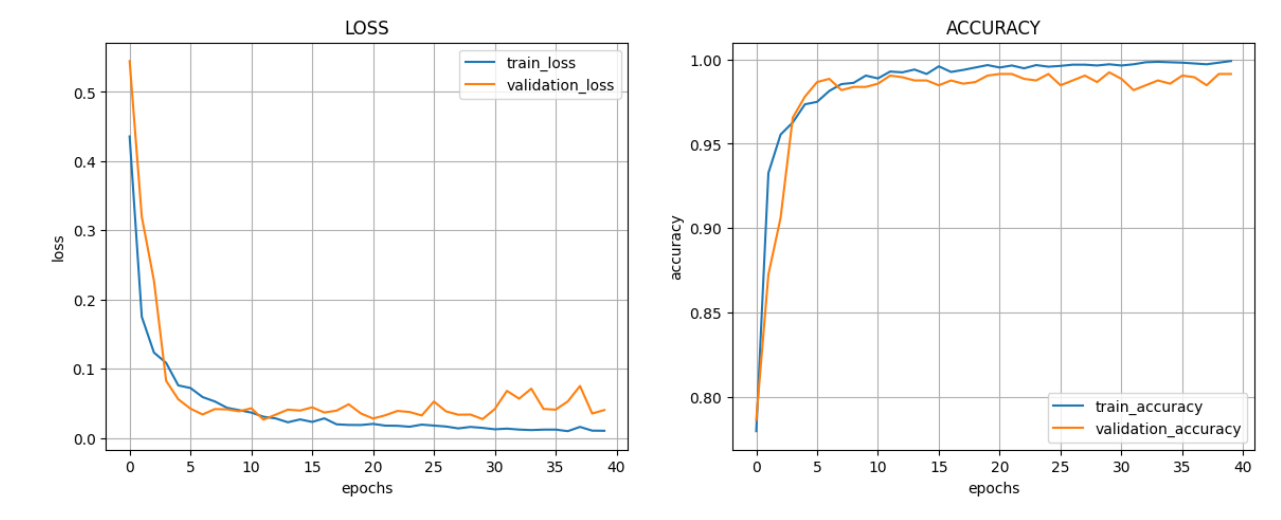

# Project-2

### Testing 디렉토리의 모든 파일을 Training 동일 디렉토리로 move

In [41]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['NORMAL', 'PNEUMONIA']


In [42]:
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1
        
    print(str(move_num) + " is moved into " + label_name + \
          "(Testing => Training)")

234 is moved into NORMAL(Testing => Training)
390 is moved into PNEUMONIA(Testing => Training)


In [43]:
for label_name in test_label_name_list:
    val_path = os.path.join(VALIDATION_DATA_ROOT_DIR, label_name)
    val_file_list = os.listdir(val_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file),
                   os.path.join(train_path, val_file))
        move_num = move_num + 1
        
    print(str(move_num) + " is moved into " + label_name + \
          "(Testing => Training)")

8 is moved into NORMAL(Testing => Training)
8 is moved into PNEUMONIA(Testing => Training)


### move 완료된 Trainning 전체 데이터 갯수 확인

In [44]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1583
train label :  PNEUMONIA  =>  4273


### Shuffle 후 다시 Tesing으로 move

In [45]:
##### move할 파일의 비율
MOVE_RATIO = 0.2

In [46]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)
    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name,
                                                 len(train_data_file_list)))

    # data shuffle
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))
    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')


total [NORMAL] data file nums => [1583]
train data shuffle is done !!!
split nums =>  316
total move nums =>  316
total [PNEUMONIA] data file nums => [4273]
train data shuffle is done !!!
split nums =>  854
total move nums =>  854


In [47]:
##### 훈련 데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('test label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    
print('=====================================================')


['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1267
train label :  PNEUMONIA  =>  3419
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  316
test label :  PNEUMONIA  =>  854


### Image Shape 설정

In [48]:
IMG_WIDTH = 224 # GPU 사용시 224로 설정
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [61]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset = "training")

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              subset = "validation")


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))



Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [51]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [52]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]
print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]


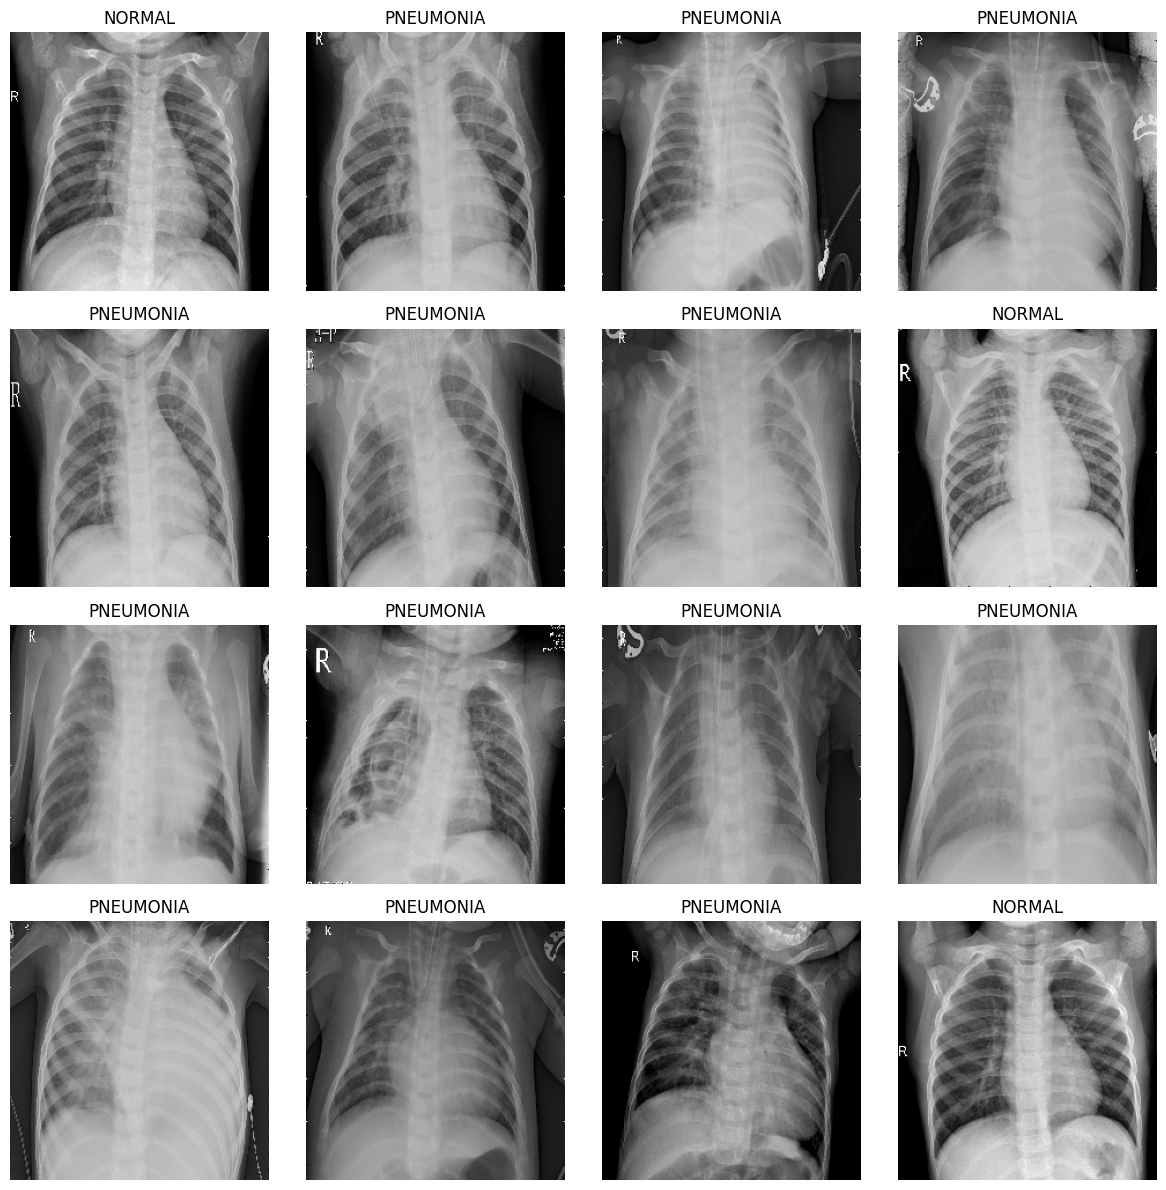

In [53]:
plt.figure(figsize=(12, 12))

class_dict = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(len(label)):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [54]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [72]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                16400     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
No

In [73]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(2e-5), metrics=["accuracy"])

In [55]:
# Test image 와 validation image 값의 balance 를 재배열 후 같은 model architecutre 로 학습
start_time = datetime.now()

result = model.fit(train_generator, epochs= 40, validation_data=validation_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/40


2023-07-05 16:55:47.073951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9843

2023-07-05 16:56:15.311220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - 35s 296ms/step - loss: 0.1066 - accuracy: 0.9843 - val_loss: 0.1079 - val_accuracy: 0.9605
Epoch 2/40
118/118 [==============================] - 34s 286ms/step - loss: 0.0405 - accuracy: 0.9896 - val_loss: 0.0929 - val_accuracy: 0.9669
Epoch 3/40
118/118 [==============================] - 34s 282ms/step - loss: 0.0309 - accuracy: 0.9925 - val_loss: 0.0949 - val_accuracy: 0.9701
Epoch 4/40
118/118 [==============================] - 34s 282ms/step - loss: 0.0243 - accuracy: 0.9944 - val_loss: 0.0913 - val_accuracy: 0.9776
Epoch 5/40
118/118 [==============================] - 34s 288ms/step - loss: 0.0194 - accuracy: 0.9963 - val_loss: 0.0923 - val_accuracy: 0.9765
Epoch 6/40
118/118 [==============================] - 35s 291ms/step - loss: 0.0144 - accuracy: 0.9976 - val_loss: 0.1084 - val_accuracy: 0.9765
Epoch 7/40
118/118 [==============================] - 34s 284ms/step - loss: 0.0152 - accuracy: 0.9968 - val_loss: 0.1005 - val_accuracy: 0.9

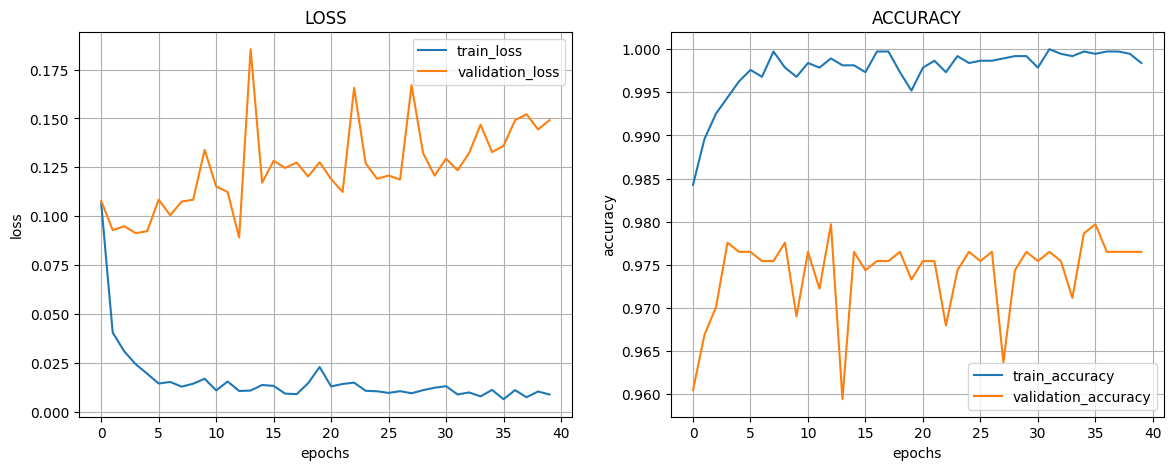

In [66]:
#LOSS graph
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

#ACCURACY graph
plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")


In [57]:
print(model.evaluate(test_generator))

2023-07-05 17:19:00.622876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


37/37 [==============================] - 10s 255ms/step - loss: 0.0528 - accuracy: 0.9923
[0.052845001220703125, 0.9923076629638672]


In [59]:
print(model.evaluate(train_generator))

2023-07-05 17:19:32.591474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - 27s 227ms/step - loss: 1.7179e-06 - accuracy: 1.0000
[1.7178815596707864e-06, 1.0]


In [62]:
test_simple_dataget = ImageDataGenerator(rescale = 1./255)

test_simple_generator = train_datagen.flow_from_directory(VALIDATION_DATA_ROOT_DIR,
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 0 images belonging to 2 classes.


In [63]:
model.evaluate(test_simple_generator)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [ ]:
### validation data set data 가 split 되어 있지 않아서 이런 현상이 일어 났다
## train, test, validation split code 를 확인 후 model train 을 확인 필요

-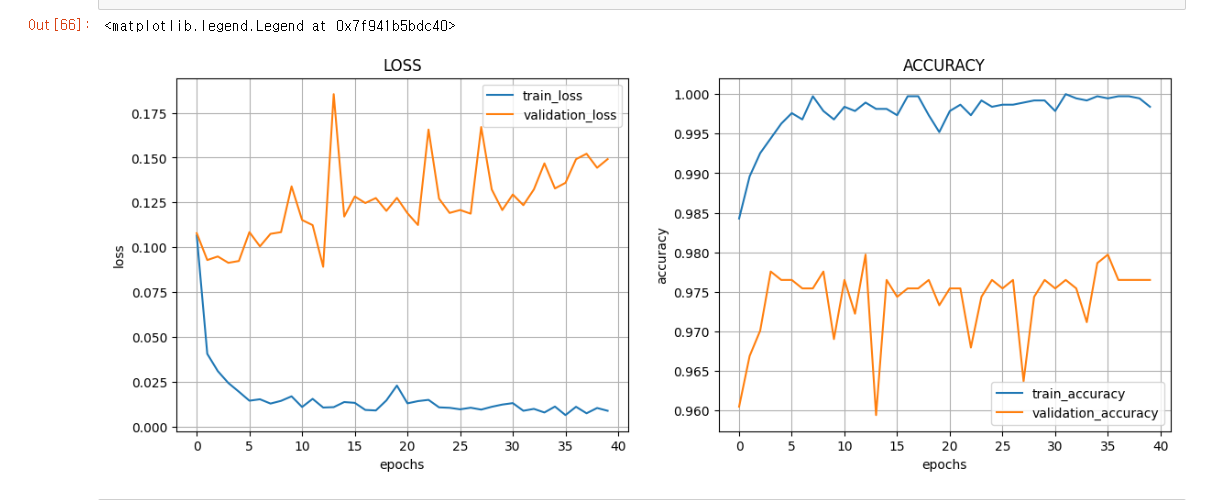